In [1]:
!wget https://github.com/karencfisher/AI-Academy-ML-capstone/raw/main/Project/LSTMfiles.zip
!unzip LSTMfiles.zip

--2022-12-04 19:32:59--  https://github.com/karencfisher/AI-Academy-ML-capstone/raw/main/Project/LSTMfiles.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/karencfisher/AI-Academy-ML-capstone/main/Project/LSTMfiles.zip [following]
--2022-12-04 19:32:59--  https://raw.githubusercontent.com/karencfisher/AI-Academy-ML-capstone/main/Project/LSTMfiles.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658695 (1.6M) [application/zip]
Saving to: ‘LSTMfiles.zip’

LSTMfiles.zip       100%[===================>]   1.58M  --.-KB/s    in 0.02s   

2022-12-04 19:33:00 (81.5 MB/s) - ‘LSTMfiles.zip’ saved 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import os
import time

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from LSTM.TR_preprocess import preprocess
from LSTM.LSTM_classifier import BiLSTMclf
from tools.tools import evaluate

#### Load training and test data sets

In [4]:
pos_train_path = os.path.join('Data', 'pos_train.csv')
pos_train = pd.read_csv(pos_train_path)

neg_train_path = os.path.join('Data', 'neg_train.csv')
neg_train = pd.read_csv(neg_train_path)

pos_test_path = os.path.join('Data', 'pos_test.csv')
pos_test = pd.read_csv(pos_test_path)

neg_test_path = os.path.join('Data', 'neg_test.csv')
neg_test = pd.read_csv(neg_test_path)

#### Preprocessing data

Reconstructs data into regularly intervaled time sequences (10 minut intervals)

In [5]:
print('Preprocessing training data...')
train_data, train_labels = preprocess(pos_train, neg_train, encode=False)
input_shape = train_data.shape
print(f'Train data shape: {train_data.shape} train labels shape: {train_labels.shape}')

train_data = train_data.tolist()
train_labels = train_labels.tolist()

print('Preprocessing test data...')
test_data, test_labels = preprocess(pos_test, neg_test, encode=False)
print(f'Test data shape: {test_data.shape} test labels shape: {test_labels.shape}')

test_data = test_data.tolist()
test_labels = test_labels.tolist()

Preprocessing training data...


generate: 100%|██████████| 357/357 [00:05<00:00, 66.88it/s]


Train data shape: (716, 1334, 5) train labels shape: (716,)
Preprocessing test data...


generate: 100%|██████████| 37/37 [00:00<00:00, 114.75it/s]

Test data shape: (74, 1334, 5) test labels shape: (74,)


#### Instantiate Bidirectional LSTM model

In [ ]:
clf = BiLSTMclf(input_shape)
clf.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 1334, 5)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 400)              329600    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 330,001
Trainable params: 330,001
Non-trainable params: 0
_________________________________________________________________


#### Train different batch sizes with 5-fold cross validation

In [ ]:
batch_sizes = [32, 64, 128, 256]
results = []
start_time = time.time()
for batch_size in batch_sizes:
    print(f'Cross validation with batch size {batch_size}.')
    metrics = clf.trainCV(train_data, train_labels, 5, batch_size, 10)
    metrics['batch_size'] = batch_size
    results.append(metrics)

    model_path = os.path.join('/content/drive/MyDrive/LSTM', f'LSTM{batch_size}.h5')
    clf.model.save(model_path)

elapsed_time = time.time() - start_time
results_df = pd.DataFrame(results, columns=['batch_size', 'accuracy', 'precision', 
                                            'recall', 'f1', 'auc'])
hr = int(elapsed_time // 3600)
elapsed_time %= 3600
min = int(elapsed_time // 60)
sec = elapsed_time % 60
print(f'Total time: {hr:02d}:{min:02d}:{sec:0.2f}')

result_path = os.path.join('/content/drive/MyDrive/LSTM', 'results.csv')
results_df.to_csv(result_path)
results_df


Cross validation with batch size 32.
Beginning training LSTM with 5-fold validation...
Epoch 1/10
18/18 [==============================] - 107s 5s/step - loss: 0.6328 - accuracy: 0.6283
Epoch 2/10
18/18 [==============================] - 98s 5s/step - loss: 0.5998 - accuracy: 0.6632
Epoch 3/10
18/18 [==============================] - 97s 5s/step - loss: 0.5961 - accuracy: 0.6719
Epoch 4/10
18/18 [==============================] - 97s 5s/step - loss: 0.5781 - accuracy: 0.6789
Epoch 5/10
18/18 [==============================] - 96s 5s/step - loss: 0.5657 - accuracy: 0.6963
Epoch 6/10
18/18 [==============================] - 97s 5s/step - loss: 0.5370 - accuracy: 0.7155
Epoch 7/10
18/18 [==============================] - 95s 5s/step - loss: 0.5140 - accuracy: 0.7469
Epoch 8/10
18/18 [==============================] - 95s 5s/step - loss: 0.4987 - accuracy: 0.7452
Epoch 9/10
18/18 [==============================] - 94s 5s/step - loss: 0.5001 - accuracy: 0.7557
Epoch 10/10
5/5 [=============

,batch_size,accuracy,precision,recall,f1,auc
0,32,0.629371,0.685039,0.484680,0.567700,0.629980
1,64,0.548252,0.554545,0.509749,0.531205,0.548414
2,128,0.495105,0.496855,0.440111,0.466765,0.495337
3,256,0.629371,0.662069,0.534819,0.591680,0.629769


#### Evaluate selected model

We will pick the best of the four trained above, and use it to predict on the test data. 

3/3 [==============================] - 6s 631ms/step
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        37
           1       0.85      0.89      0.87        37

    accuracy                           0.86        74
   macro avg       0.87      0.86      0.86        74
weighted avg       0.87      0.86      0.86        74



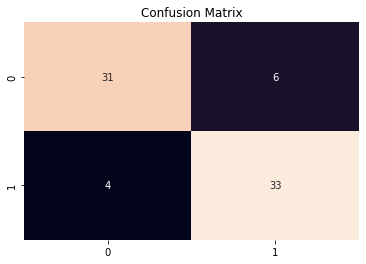

In [6]:
model_path = os.path.join('/content/drive/MyDrive/LSTM', 'LSTM256.h5')
clf = load_model(model_path, compile=False)

pred = clf.predict(test_data).reshape(-1)
pred = (pred > 0.5).astype(int)
metrics = evaluate(test_labels, pred)

print(classification_report(test_labels, pred))
cm = confusion_matrix(test_labels, pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [7]:
import json

json_path = os.path.join('/content/drive/MyDrive/LSTM', 'metrics.json')
with open(json_path, 'w') as FP:
    json.dump(metrics, FP)